# LangGraph Agent with Human in the Loop - Breakpoints

### llm setup for LangChain

In [2]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
load_dotenv()

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash',temperature=0)


### tools

In [3]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def get_weather(city: str, unit: str = 'celsius') -> str:
	"""Get the weather for a city."""
	return f"The weather in {city} is 25 degrees {unit}."

@tool
def web_search(query: str) -> str:
	"""Search the web for a query."""
	tavily_search_tool = TavilySearch(
		max_results=5,
		topic="general",
	)
	return tavily_search_tool.invoke(query)

TOOL_MAP = {
	"get_weather": get_weather,
	"web_search": web_search,
}

### Add tools to the llm

In [4]:
llm = llm.bind_tools([get_weather, web_search])

### State - Message from Langchain

In [5]:
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage

from langgraph.graph.message import add_messages # add_messages is the reducer to add messages to the state

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

### Node

In [6]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(
		content="You are a helpful tour planning assistant that can help users for making itinerary. You can plan the trip from checking the weather, searching for rooms and searching interesitng things and places to go out for.",
	)

def react_agent(state: MessagesState):
	llm_output = llm.invoke([sys_msg] + state["messages"])
	return {"messages": [llm_output]}

### adding memory

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

config = {"configurable": {"thread_id": "1"}}

### Build Graph

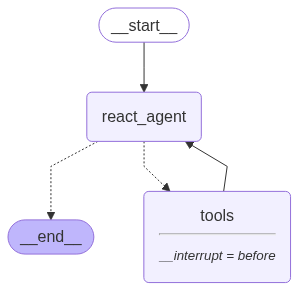

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(MessagesState)
builder.add_node("react_agent", react_agent)
builder.add_node("tools", ToolNode([get_weather, web_search]))
builder.add_edge(START, "react_agent")
builder.add_conditional_edges(
	"react_agent",
	tools_condition
)
builder.add_edge("tools", "react_agent")
graph = builder.compile(interrupt_before=['tools'], checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke Graph

#### a. simple message - requring no tools

In [18]:
messages = graph.invoke({"messages": [HumanMessage(content="What up!")]}, config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What up!
================================== Ai Message ==================================

Hello! I'm here to help you plan your next trip. What can I do for you?


#### b. tool calling - invoking all tools

In [19]:
messages = graph.invoke({"messages": [HumanMessage(content="Plan a trip to San Francisco, for next weekend")]}, config=config)
for m in messages['messages']:
	m.pretty_print()

================================ Human Message =================================

What up!
================================== Ai Message ==================================

Hello! I'm here to help you plan your next trip. What can I do for you?
================================ Human Message =================================

Plan a trip to San Francisco, for next weekend
================================== Ai Message ==================================
Tool Calls:
  get_weather (a6820aaa-5bce-4548-99d3-d5e4a9881d8b)
 Call ID: a6820aaa-5bce-4548-99d3-d5e4a9881d8b
  Args:
    city: San Francisco


### check the state

In [20]:
state = graph.get_state(config)
state.next

('tools',)

In [21]:
graph.get_state(config).values

{'messages': [HumanMessage(content='What up!', additional_kwargs={}, response_metadata={}, id='e8495142-319a-4fa6-88b7-9407dae4fcad'),
  AIMessage(content="Hello! I'm here to help you plan your next trip. What can I do for you?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--a62ed2ad-5d26-479f-95d8-3626f54624b1-0', usage_metadata={'input_tokens': 138, 'output_tokens': 21, 'total_tokens': 159, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='Plan a trip to San Francisco, for next weekend', additional_kwargs={}, response_metadata={}, id='6d9d471f-5852-4b5e-b418-49ac852a545b'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "San Francisco"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'ge

#### proceeding... 
`Note`: that we have two tools and only one was executed and interrupted before invoking the second tool - the web search one

In [22]:
async for event in graph.astream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_weather (a6820aaa-5bce-4548-99d3-d5e4a9881d8b)
 Call ID: a6820aaa-5bce-4548-99d3-d5e4a9881d8b
  Args:
    city: San Francisco
================================= Tool Message =================================
Name: get_weather

The weather in San Francisco is 25 degrees celsius.
================================== Ai Message ==================================
Tool Calls:
  web_search (08d901e2-959a-4da1-a472-92b4cb4bff11)
 Call ID: 08d901e2-959a-4da1-a472-92b4cb4bff11
  Args:
    query: things to do in San Francisco


#### lets make it invoke the next tool call...

In [23]:
async for event in graph.astream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  web_search (08d901e2-959a-4da1-a472-92b4cb4bff11)
 Call ID: 08d901e2-959a-4da1-a472-92b4cb4bff11
  Args:
    query: things to do in San Francisco
================================= Tool Message =================================
Name: web_search

{"query": "things to do in San Francisco", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.tripadvisor.com/Attractions-g60713-Activities-San_Francisco_California.html", "title": "THE 15 BEST Things to Do in San Francisco (2025) - Tripadvisor", "content": "Check out must-see sights and activities: Alcatraz Island, Golden Gate Bridge, City Tours, Wine Tastings. For personalized recommendations, try our AI trip-", "score": 0.8616433, "raw_content": null}, {"url": "https://mycaliforniatravels.com/top-things-to-do-in-san-francisco/", "title": "Top 23 Things to Do in San Francisco for First-time Visitors", "content

#### flow of state

![flow.jpg](https://camo.githubusercontent.com/45a2c63cc3140b3db106fa6544c2ede29fff7ea4b6a41269299585609bba09d8/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261653739383562373437646665643637373735645f627265616b706f696e7473312e706e67)

##### reference: https://camo.githubusercontent.com/45a2c63cc3140b3db106fa6544c2ede29fff7ea4b6a41269299585609bba09d8/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261653739383562373437646665643637373735645f627265616b706f696e7473312e706e67

### Full example

In [15]:
init_state = {
  "messages": [HumanMessage(content="hi! I'm Alice, Plan a three day winding down vacation, end of July to up Niagra NY")]
}

thread = {"configurable": {"thread_id": "11"}}

async for event in graph.astream(init_state, config=thread, stream_mode='values'):
    event['messages'][-1].pretty_print()

shall_we_proceed = input("Shall we proceed with checking weather? (y/n): ")

if shall_we_proceed == "y":
    async for event in graph.astream(None, config=thread, stream_mode='values'):
        event['messages'][-1].pretty_print()
else:
    print('Until next time!')
    exit()

shall_we_proceed = input("Shall we proceed with searching the web? (y/n): ")

if shall_we_proceed == "y":
    async for event in graph.astream(None, config=thread, stream_mode='values'):
        event['messages'][-1].pretty_print()
else:
    print('Until next time!')
    exit()




================================ Human Message =================================

hi! I'm Alice, Plan a three day winding down vacation, end of July to up Niagra NY
================================== Ai Message ==================================

Hi Alice! I can help you plan a relaxing three-day vacation to Niagara Falls, NY, at the end of July.

To start, I'll need to check the weather for Niagara Falls, NY, around that time.
Tool Calls:
  get_weather (ddb7acf8-be9e-4a2f-8c01-bb7b620a7d43)
 Call ID: ddb7acf8-be9e-4a2f-8c01-bb7b620a7d43
  Args:
    city: Niagara Falls, NY
================================== Ai Message ==================================

Hi Alice! I can help you plan a relaxing three-day vacation to Niagara Falls, NY, at the end of July.

To start, I'll need to check the weather for Niagara Falls, NY, around that time.
Tool Calls:
  get_weather (ddb7acf8-be9e-4a2f-8c01-bb7b620a7d43)
 Call ID: ddb7acf8-be9e-4a2f-8c01-bb7b620a7d43
  Args:
    city: Niagara Falls, NY
=====

### Edit State during interruption

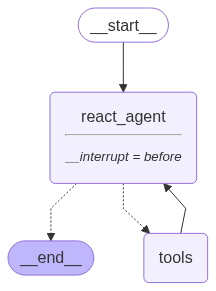

In [30]:
# interrupt before chat node

from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder = StateGraph(MessagesState)
builder.add_node("react_agent", react_agent)
builder.add_node("tools", ToolNode([get_weather, web_search]))
builder.add_edge(START, "react_agent")
builder.add_conditional_edges(
	"react_agent",
	tools_condition
)
builder.add_edge("tools", "react_agent")
graph = builder.compile(interrupt_before=['react_agent'], checkpointer=memory)


display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "14"}}

init_state = {
  "messages": [HumanMessage(content="hi! I'm Alice, Plan a three day winding down vacation, end of July to up Niagra NY")]
}

async for event in graph.astream(init_state, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hi! I'm Alice, Plan a three day winding down vacation, end of July to up Niagra NY


In [32]:
graph.update_state(
    config,
    {
        "messages": [HumanMessage(content="You know what, lets go somewhere in the west coast, mmm... Seattle, WA")]
    }
)

{'configurable': {'thread_id': '14',
  'checkpoint_ns': '',
  'checkpoint_id': '1f068346-56fa-6164-8001-3d5b6bcc446d'}}

### lets get the curr state and proceed the flow

In [33]:
current_state = graph.get_state(config).values
# print the state messages
for m in current_state['messages']:
    m.pretty_print()

================================ Human Message =================================

hi! I'm Alice, Plan a three day winding down vacation, end of July to up Niagra NY
================================ Human Message =================================

You know what, lets go somewhere in the west coast, mmm... Seattle, WA


In [34]:
async for event in graph.astream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

You know what, lets go somewhere in the west coast, mmm... Seattle, WA
================================== Ai Message ==================================
Tool Calls:
  get_weather (90b00834-1875-474a-b084-95ca2aa7b459)
 Call ID: 90b00834-1875-474a-b084-95ca2aa7b459
  Args:
    city: Seattle, WA
    unit: fahrenheit
  web_search (2a6f7922-ee98-48f2-91f0-a8b0da7546fc)
 Call ID: 2a6f7922-ee98-48f2-91f0-a8b0da7546fc
  Args:
    query: average weather Seattle end of July
================================= Tool Message =================================
Name: web_search

{"query": "average weather Seattle end of July", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Seattle", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Seattle', 'region': 'Washington', 'country': 'United States of America', 'lat': 47.6064, 'lon': -122.3308, 'tz_id': 'America/

In [35]:
# final state goes back to the agent, lets call it now

async for event in graph.astream(None, config=config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: web_search

{"query": "average weather Seattle end of July", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Seattle", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Seattle', 'region': 'Washington', 'country': 'United States of America', 'lat': 47.6064, 'lon': -122.3308, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1753323748, 'localtime': '2025-07-23 19:22'}, 'current': {'last_updated_epoch': 1753323300, 'last_updated': '2025-07-23 19:15', 'temp_c': 26.7, 'temp_f': 80.1, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 7.6, 'wind_kph': 12.2, 'wind_degree': 337, 'wind_dir': 'NNW', 'pressure_mb': 1014.0, 'pressure_in': 29.95, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 44, 'cloud': 0, 'feelslike_c': 28.1, 'feelslike_f': 82.6, 'windchill_c': 2